In [2]:
import pandas as pd
import torch
from dictionary_learning import ActivationBuffer, AutoEncoder, GatedAutoEncoder
from dictionary_learning.trainers import StandardTrainer, GatedSAETrainer
from dictionary_learning.training import trainSAE
from nnsight import LanguageModel
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from transformers import pipeline
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizer
os.environ["WANDB_DISABLED"] = "true"

import gc

def clean():
    torch.cuda.empty_cache()
    gc.collect()
    
torch.cuda.empty_cache()
gc.collect()

from sklearn.metrics import classification_report as cr
from sklearn.metrics import *
from tqdm import tqdm
from sklearn.model_selection import train_test_split as tts

In [5]:
# Load the dataset
splits = {'train': 'train.csv', 'test': 'test.csv'}
train_data = pd.read_csv("hf://datasets/holistic-ai/EMGSD/" + splits["train"])
test_data = pd.read_csv("hf://datasets/holistic-ai/EMGSD/" + splits["test"])

device='cuda'
model = DistilBertForSequenceClassification.from_pretrained('./fine_tuned_distilbert').to(device)
tokenizer = DistilBertTokenizer.from_pretrained('./fine_tuned_distilbert')
model = LanguageModel(model, tokenizer=tokenizer)

In [3]:
#Map the targets
ma = {'unrelated':0,
      'stereotype':1,
      'neutral':2
     }

y = train_data['category'].map(ma)
y_test = test_data['category'].map(ma)

In [4]:
#Tokenize the train and test set
enc = tokenizer(train_data['text'].values.tolist(), return_tensors='pt', truncation=True, padding="max_length")
test_enc = tokenizer(test_data['text'].values.tolist(), return_tensors='pt', truncation=True, padding="max_length")

In [5]:

#Validate performance on the test set
all_pred = []
with torch.no_grad():
    for i in tqdm(range(0, len(test_data), 32)):
        inp = test_enc['input_ids'][i:i+32].to(device)
        att = test_enc['attention_mask'][i:i+32].to(device)

        pred = model(inp, att)
        pred = torch.nn.functional.softmax(pred.logits).argmax(dim=1).detach().cpu().numpy()
        
        all_pred.append(pred)
        #print(cr(y_test[i:i+32], pred))
all_pred = np.concatenate(all_pred)

  0%|          | 0/358 [00:00<?, ?it/s]/tmp/ipykernel_16378/2605603318.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(pred.logits).argmax(dim=1).detach().cpu().numpy()
100%|██████████| 358/358 [00:44<00:00,  8.10it/s]


In [6]:
#DistillBert performance on test set
print(cr(y_test, all_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3781
           1       0.77      0.77      0.77      3906
           2       0.74      0.75      0.75      3754

    accuracy                           0.82     11441
   macro avg       0.82      0.82      0.82     11441
weighted avg       0.82      0.82      0.82     11441



In [7]:
from nnsight import NNsight
#Load in model, cuda is crucial
device='cuda'
model = DistilBertForSequenceClassification.from_pretrained('./fine_tuned_distilbert')
model.to(device)
tokenizer = DistilBertTokenizer.from_pretrained('./fine_tuned_distilbert')
model = LanguageModel(model, tokenizer=tokenizer)

def train_SAE(inp):
    
    #Define config for training SAE 
    trainer_cfg = {
        "trainer": StandardTrainer,
        "dict_class": AutoEncoder,
        "activation_dim": 768,
        "dict_size": 8*768,
        "lr": 1e-3,
        'l1_penalty':0.1,
        "device": device,
        'layer':"Bob",
        'lm_name':"gf"
    }

    dataset = TensorDataset(inp)  # Input and target are the same
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

    # Train the sparse autoencoder (SAE), SAE directory needed.
    ae = trainSAE(
        data=dataloader,  
        trainer_configs=[trainer_cfg],
        save_dir = "SAE",
    )
    #
    ae = AutoEncoder.from_pretrained("./SAE/trainer_0/ae.pt").to(device)
    clean()
    return ae


def evaluate(ae, inp):
    with torch.no_grad():
        
        dictionary = ae
        x = inp[:10000].to(device)
        out={}

        x_hat, f = dictionary(x, output_features=True)
        l2_loss = torch.linalg.norm(x - x_hat, dim=-1).mean()
        trivial_l2 = torch.linalg.norm(x - x.mean(dim=0), dim=-1).mean()
        l1_loss = f.norm(p=1, dim=-1).mean()
        l0 = (f != 0).float().sum(dim=-1).mean()
        #frac_alive = torch.flatten(f, start_dim=0, end_dim=1).any(dim=0).sum() / dictionary.dict_size

        # cosine similarity between x and x_hat
        x_normed = x / (torch.linalg.norm(x, dim=-1, keepdim=True) + 1e-6)
        x_hat_normed = x_hat / (torch.linalg.norm(x_hat, dim=-1, keepdim=True) + 1e-6)
        cossim = (x_normed * x_hat_normed).sum(dim=-1).mean()

        # l2 ratio
        l2_ratio = ((torch.linalg.norm(x_hat, dim=-1)+1e-3) / (torch.linalg.norm(x, dim=-1)+1e-3)).mean()

        #compute variance explained
        total_variance = torch.var(x, dim=0).sum()
        residual_variance = torch.var(x - x_hat, dim=0).sum()
        frac_variance_explained = (1 - residual_variance / total_variance)

        # Equation 10 from https://arxiv.org/abs/2404.16014
        x_hat_norm_squared = torch.linalg.norm(x_hat, dim=-1, ord=2)**2
        x_dot_x_hat = (x * x_hat).sum(dim=-1)
        relative_reconstruction_bias = x_hat_norm_squared.mean() / x_dot_x_hat.mean()

        out["l2_loss"] = l2_loss.item()
        out['trivial_l2'] = trivial_l2.item()
        out["l1_loss"] = l1_loss.item()
        out["l0"] = l0.item()
        #out["frac_alive"] = frac_alive.item()
        out["frac_variance_explained"] = frac_variance_explained.item()
        out["cossim"] = cossim.item()
        out["l2_ratio"] = l2_ratio.item()
        out['relative_reconstruction_bias'] = relative_reconstruction_bias.item()
    
    return out

In [8]:
#Separate dataset in the catogories
unrel   = train_data[train_data['category']=="unrelated"]
stereo  = train_data[train_data['category']=="stereotype"]
neutral = train_data[train_data['category']=="neutral"]

In [9]:
#Tokenize data by category

all_text = train_data['text'].values.tolist()
stereo_text = stereo['text'].values.tolist()
neutral_text = neutral['text'].values.tolist()
unrel_text = unrel['text'].values.tolist()

stereo_tokens  = []
neutral_tokens = []
unrel_tokens   = []
all_tokens     = []

for line in tqdm(all_text):
    all_tokens.append(tokenizer.encode(line, padding='max_length', max_length=96, padding_side='right'))

for line in tqdm(stereo_text):
    stereo_tokens.append(tokenizer.encode(line, padding='max_length', max_length=96, padding_side='right'))

for line in tqdm(neutral_text):
    neutral_tokens.append(tokenizer.encode(line, padding='max_length', max_length=96, padding_side='right'))

for line in tqdm(unrel_text):
    unrel_tokens.append(tokenizer.encode(line, padding='max_length', max_length=96, padding_side='right'))


all_tokens = torch.Tensor(all_tokens).long()
neutral_tokens = torch.Tensor(neutral_tokens).long()
stereo_tokens = torch.Tensor(stereo_tokens).long()
unrel_tokens = torch.Tensor(unrel_tokens).long()

100%|██████████| 14992/14992 [00:05<00:00, 2770.95it/s]


In [10]:
#Create a dataset of model activations of MLP in transformer layer 3
all_samples = []

with torch.no_grad():
    for i in tqdm(range(0, len(all_tokens), 256)):
            
        sub = all_tokens[i:i+64]
            
        with model.trace(sub, (sub!=0).long()) as tracer:
            mlp_0 = model.distilbert.transformer.layer[2].ffn.output.save()
            model.distilbert.transformer.layer[2].ffn.output.stop()
        
        mlp_0 = mlp_0.detach().cpu()
        mlp_0 = mlp_0.reshape((-1, mlp_0.shape[-1])).detach().cpu()
        
        #print(mlp_0.shape)
        mask = (sub!=0).flatten()
        mlp_0 = mlp_0[mask]
        #print(mlp_0.shape)
        
        all_samples.append(mlp_0)
        
all_samples = torch.cat(all_samples)
print(all_samples.shape)

100%|██████████| 179/179 [00:07<00:00, 24.86it/s]


torch.Size([176187, 768])


In [11]:
#Train the SAE and validate evaluation metrics
#L2_loss, mse between input and reconstruction
#Trivial_ls, mse between input and average vector, baseline
#L1_loss, l1 norm on the features
#L0, Average number of non-zero features
#Frac_variance, sort of a r^2 score between input and reconstruction
#Cossim, cosine similarity between input and reconstruction

ae = train_SAE(all_samples)
out = evaluate(ae, all_samples)

out

100%|██████████| 1377/1377 [00:04<00:00, 337.89it/s]
/home/ec2-user/SageMaker/dictionary_learning/dictionary.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict 

{'l2_loss': 7.6188154220581055,
 'trivial_l2': 32.69347381591797,
 'l1_loss': 22.25795555114746,
 'l0': 5.999199867248535,
 'frac_variance_explained': 0.9816416501998901,
 'cossim': 0.5862250328063965,
 'l2_ratio': 0.4908371865749359,
 'relative_reconstruction_bias': 0.9975578188896179}

In [12]:
#SAE features on stereotype input
stereo_tok = []
stereo_feat = []
with torch.no_grad():
    for i in tqdm(range(0, len(stereo_tokens), 256)):
        sub = stereo_tokens[i:i+64]
        
        with model.trace(sub, (sub!=0).long()) as tracer:
            mlp_0 = model.distilbert.transformer.layer[2].ffn.output.save()
            model.distilbert.transformer.layer[2].ffn.output.stop()
        
        features = ae.encode(mlp_0).detach().cpu()
        features = features.reshape((-1, features.shape[-1]))
        
        tokens = sub.flatten()
        
        mask = (tokens!=0)
        
        tokens = tokens[mask]
        features = features[mask]
        
        stereo_tok.append(tokens)
        stereo_feat.append(features)

stereo_tok = torch.cat(stereo_tok)
stereo_feat = torch.cat(stereo_feat)

print(stereo_tok.shape, stereo_feat.shape)

100%|██████████| 61/61 [00:03<00:00, 16.87it/s]


torch.Size([61160]) torch.Size([61160, 6144])


In [13]:
#SAE features on stereotype input

neut_tok = []
neut_feat = []
with torch.no_grad():
    for i in tqdm(range(0, len(neutral_tokens), 256)):
        
        sub = neutral_tokens[i:i+64]
        
        with model.trace(sub, (sub!=0).long()) as tracer:
            mlp_0 = model.distilbert.transformer.layer[2].ffn.output.save()
            model.distilbert.transformer.layer[2].ffn.output.stop()
        
        features = ae.encode(mlp_0).detach().cpu()
        features = features.reshape((-1, features.shape[-1])).detach().cpu()
        
        tokens = sub.flatten()
        
        mask = (tokens!=0)
        
        tokens = tokens[mask]
        features = features[mask]
        
        neut_tok.append(tokens)
        neut_feat.append(features)

neut_tok = torch.cat(neut_tok)
neut_feat = torch.cat(neut_feat)

print(neut_tok.shape, neut_feat.shape)

100%|██████████| 60/60 [00:03<00:00, 16.78it/s]


torch.Size([60389]) torch.Size([60389, 6144])


In [14]:
#Average of feature activation over samples per category
stereo_feat_mean = stereo_feat.mean(dim=0)
neut_feat_mean   = neut_feat.mean(dim=0)


<Axes: >

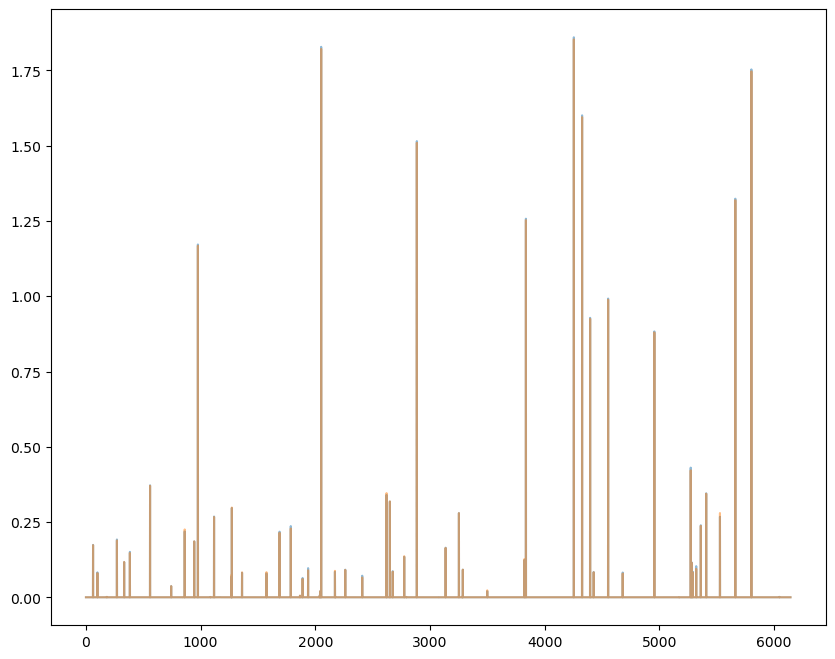

In [15]:
#Plot of average feature activation over stereotype data and neutral data
plt.figure(figsize=(10, 8))

sns.lineplot(stereo_feat_mean, alpha=0.5)
sns.lineplot(neut_feat_mean, alpha=0.5)


<Axes: >

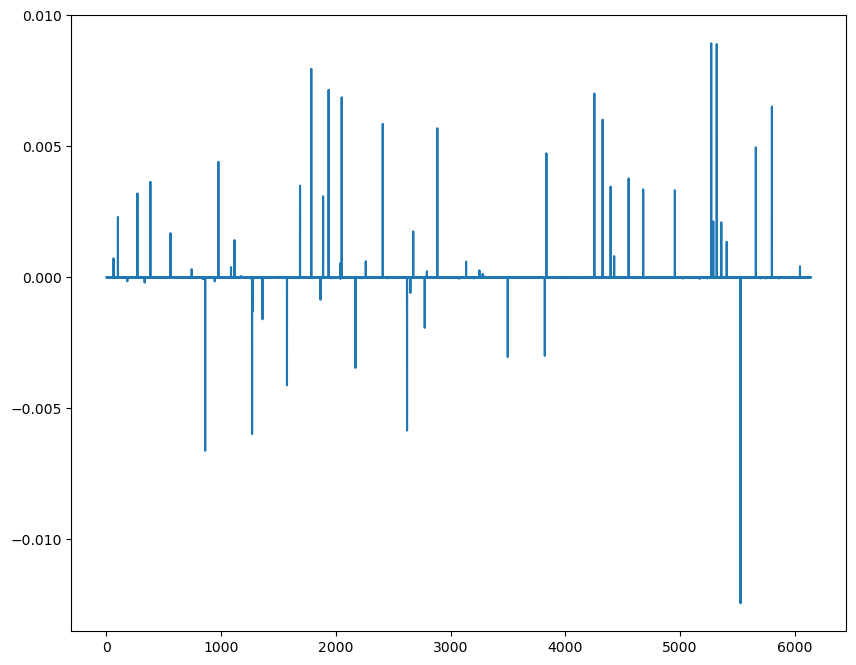

In [16]:
#Difference between stereotype features and neutral activations
plt.figure(figsize=(10, 8))

sns.lineplot(stereo_feat_mean-neut_feat_mean)

In [17]:

val, chosen = (stereo_feat_mean-neut_feat_mean).abs().topk(5)
print(val, chosen)

tensor([0.0124, 0.0089, 0.0089, 0.0080, 0.0072]) tensor([5528, 5273, 5321, 1786, 1937])


In [18]:
pl = stereo_tok.clone()
pa = stereo_feat.clone()

In [19]:
# Initialize dictionaries
token_dic = {unq.item(): [] for unq in torch.unique(pl)}
feat_dic = {feat: [] for feat in range(pa.shape[1])}

# Main loop
with torch.no_grad():
    for c, i in tqdm(enumerate(pl), total=len(pl)):
        val, ind = pa[c].topk(1)
        
        if val.max()>1:
            # Apply mask
            mask = val > 1
            ind = ind[mask]
            val = val[mask]

            # Update token_dic
            token_dic[i.item()].extend(ind.cpu().tolist())

            # Update feat_dic
            for j in ind:
                feat_dic[j.item()].append(i.item())

# Convert to unique values
feat_dic = {k: np.unique(v) for k, v in feat_dic.items()}

100%|██████████| 61160/61160 [00:07<00:00, 8530.90it/s]


In [20]:

#Features and the inputs/tokens that activate them
#Notice that each feature is thematic, adjectives, negative conotations, pronouns, etc.
for i in feat_dic:
    if i in chosen:
        seq = feat_dic[i]
        line = [" "+tokenizer.decode([i]).strip() for i in seq]
        line = ''.join(line)
        print(i, line)
        print()

1786  to he that it his her she you this they one him their has who there its we can them could will many these family those come himself country robert talk herself sport hers

1937  ' t ’ of from but not one out would no over can only could before do than ##t under did know against don off even didn war however won away never little small few though without wasn different late lost short couldn nothing give non does far hard am less outside low rather despite wouldn lower gone bad longer fight doesn kill ##am wrong poor broke cannot difficult lack none slow haven unable refused der trouble afraid avoid di barely lose missed dangerous un aren hate push impossible poverty ill stuck scared harder hated nobody criticized ignored expensive rob rarely na hardly difficulty shorter corruption fake hasn fewer ignore questioned resist lied absent poorly lacked lacking kidnapped foul una ##shed hates une hind illegally shu ##rri scarce barren sparse sl sparsely undermine forbid uno mis unfit

5